#Import thư viện

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
import keras
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import os
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
class QWKCallback(Callback):
    def __init__(self,val_data):
        super(Callback, self).__init__()
        self.validation_data = val_data
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201_bestqwk.h5')

In [ ]:
# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [ ]:
batch_size = 32
img_size = 224

In [ ]:
X_train=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_train.npy')
Y_train=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_train.npy')
X_val=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_val.npy')
Y_val=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_val.npy')
X_test = np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_test.npy')
Y_test = np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_test.npy')


In [ ]:
len(X_train)

2442

In [ ]:
Y_train_labels = np.argmax(Y_train,axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train_labels),Y_train_labels)
cls_wt_dict = dict(enumerate(class_weights))
print(cls_wt_dict)

{0: 0.40397022332506205, 1: 1.9304347826086956, 2: 0.7333333333333333, 3: 3.7282442748091604, 4: 2.6688524590163936}


In [ ]:
datagen = ImageDataGenerator(            
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=32, alpha=0.2, datagen=datagen)()
valid_generator = ImageDataGenerator(rescale=1./255)
validation = MixupGenerator(X_val, Y_val, batch_size=32, alpha=0.2, datagen=datagen)()

In [ ]:
from tensorflow import keras
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        print(y_true)
        print(y_pred)
        epsilon = 1.e-9
        y_true = tf.dtypes.cast(y_true, tf.float32)
        #y_true = tf.convert_to_tensor(y_true, tf.float32)
        print("y_true", y_true)
        #y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)

In [ ]:
import glob
paths = glob.glob('/content/drive/MyDrive/NhanDang/Data/Data_test/*')


In [ ]:
import numpy as np

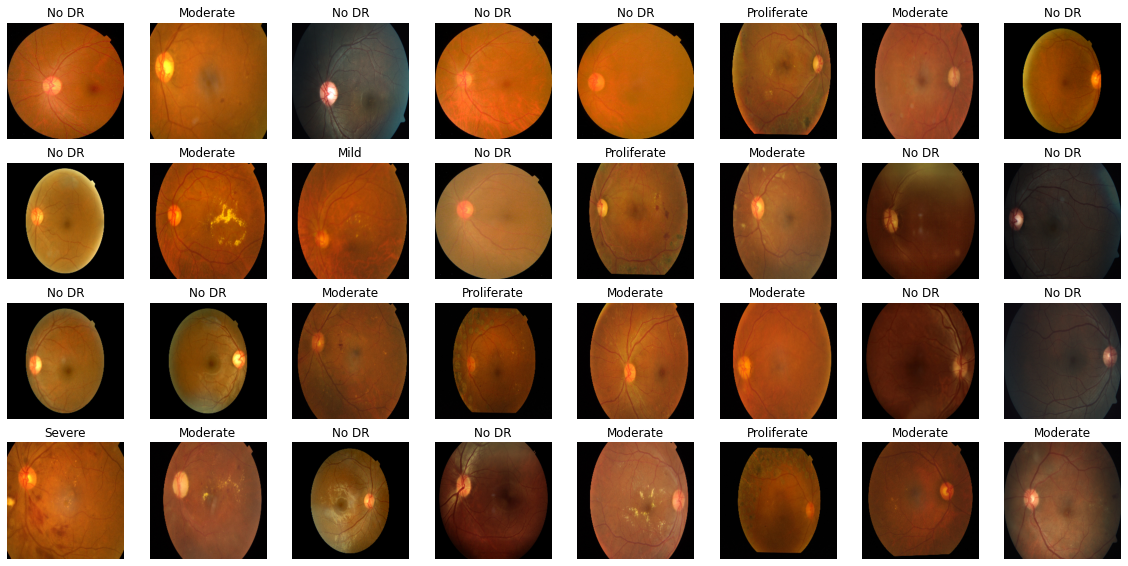

In [ ]:
class_name = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
plt.figure(figsize=(20, 15))
for i in range(32):
  ax = plt.subplot(6, 8, i + 1)
  image = plt.imread(paths[i])

  plt.imshow(image)
  plt.title(class_name[y_true[i]])
  plt.axis("off")


#Categorical Cross Entropy Loss

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
import keras
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import os
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

class QWKCallback(Callback):
    def __init__(self,val_data):
        super(Callback, self).__init__()
        self.validation_data = val_data
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201_bestqwk.h5')


from tensorflow import keras
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        print(y_true)
        print(y_pred)
        epsilon = 1.e-9
        y_true = tf.dtypes.cast(y_true, tf.float32)
        #y_true = tf.convert_to_tensor(y_true, tf.float32)
        print("y_true", y_true)
        #y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)

# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y


batch_size = 32
img_size = 224


X_train=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_train.npy')
Y_train=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_train.npy')
X_val=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_val.npy')
Y_val=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_val.npy')
X_test = np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_test.npy')
Y_test = np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_test.npy')

Y_train_labels = np.argmax(Y_train,axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train_labels),Y_train_labels)
cls_wt_dict = dict(enumerate(class_weights))
print(cls_wt_dict)

datagen = ImageDataGenerator(            
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=32, alpha=0.2, datagen=datagen)()
valid_generator = ImageDataGenerator(rescale=1./255)
validation = MixupGenerator(X_val, Y_val, batch_size=32, alpha=0.2, datagen=datagen)()


EPOCHS = 50
validation_data=(X_val, Y_val)
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201_besqwk.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]



{0: 0.40397022332506205, 1: 1.9304347826086956, 2: 0.7333333333333333, 3: 3.7282442748091604, 4: 2.6688524590163936}


In [ ]:
densenet_weights_path = '/content/drive/MyDrive/NhanDang/Data/3k6/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3),include_top=False,weights=densenet_weights_path,pooling='avg')
pretrained_model3.trainable = False
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(5, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics = ['accuracy', 'AUC'])

In [ ]:
model.fit(training_generator, epochs=2,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2
76/76 [==============================] - 840s 11s/step - loss: 1.3720 - accuracy: 0.5752 - auc: 0.7193 - val_loss: 0.7768 - val_accuracy: 0.7131 - val_auc: 0.9269

Epoch 00001: val_loss improved from inf to 0.77683, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 0 : QWK: 0.7265941027232097
saving checkpoint:  0.7265941027232097
Epoch 2/2
76/76 [==============================] - 819s 11s/step - loss: 1.2209 - accuracy: 0.6299 - auc: 0.7605 - val_loss: 0.8908 - val_accuracy: 0.5795 - val_auc: 0.8887

Epoch 00002: val_loss did not improve from 0.77683
Epoch 1 : QWK: 0.7754759396907328
saving checkpoint:  0.7754759396907328


In [ ]:
model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/5
76/76 [==============================] - 831s 11s/step - loss: 1.1494 - accuracy: 0.6678 - auc: 0.7593 - val_loss: 0.8383 - val_accuracy: 0.6189 - val_auc: 0.9084

Epoch 00001: val_loss did not improve from 0.77683
Epoch 0 : QWK: 0.7736781366957571
Epoch 2/5
76/76 [==============================] - 840s 11s/step - loss: 1.1490 - accuracy: 0.6719 - auc: 0.7720 - val_loss: 0.7859 - val_accuracy: 0.6664 - val_auc: 0.9239

Epoch 00002: val_loss did not improve from 0.77683
Epoch 1 : QWK: 0.8021257428449287
saving checkpoint:  0.8021257428449287
Epoch 3/5
76/76 [==============================] - 839s 11s/step - loss: 1.1434 - accuracy: 0.6624 - auc: 0.7607 - val_loss: 0.7225 - val_accuracy: 0.7295 - val_auc: 0.9367

Epoch 00003: val_loss improved from 0.77683 to 0.72250, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 2 : QWK: 0.786302283613449
Epoch 4/5
76/76 [==============================] - 829s 11s/step - loss: 1.1557 - accuracy: 0.6694 - auc: 0.

In [ ]:
model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/5
76/76 [==============================] - 830s 11s/step - loss: 1.0760 - accuracy: 0.6949 - auc: 0.7722 - val_loss: 0.6928 - val_accuracy: 0.7279 - val_auc: 0.9399

Epoch 00001: val_loss did not improve from 0.66687
Epoch 0 : QWK: 0.8208783001567125
saving checkpoint:  0.8208783001567125
Epoch 2/5
76/76 [==============================] - 823s 11s/step - loss: 1.0917 - accuracy: 0.7019 - auc: 0.7689 - val_loss: 0.7293 - val_accuracy: 0.7295 - val_auc: 0.9363

Epoch 00002: val_loss did not improve from 0.66687
Epoch 1 : QWK: 0.8226840649449718
saving checkpoint:  0.8226840649449718
Epoch 3/5
76/76 [==============================] - 819s 11s/step - loss: 1.0325 - accuracy: 0.7093 - auc: 0.7766 - val_loss: 0.7521 - val_accuracy: 0.6803 - val_auc: 0.9263

Epoch 00003: val_loss did not improve from 0.66687
Epoch 2 : QWK: 0.7807964045750628
Epoch 4/5
76/76 [==============================] - 820s 11s/step - loss: 1.0570 - accuracy: 0.6879 - auc: 0.7729 - val_loss: 0.7655 - val_accurac

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201_bestqwk.h5')

In [ ]:
model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
76/76 [==============================] - 78s 485ms/step - loss: 1.0840 - accuracy: 0.7007 - auc: 0.7763 - val_loss: 0.7524 - val_accuracy: 0.6918 - val_auc: 0.9281

Epoch 00001: val_loss improved from inf to 0.75242, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 0 : QWK: 0.8002793998842705
saving checkpoint:  0.8002793998842705
Epoch 2/5
76/76 [==============================] - 32s 423ms/step - loss: 1.0840 - accuracy: 0.7039 - auc: 0.7763 - val_loss: 0.8524 - val_accuracy: 0.6270 - val_auc: 0.9046

Epoch 00002: val_loss did not improve from 0.75242
Epoch 1 : QWK: 0.7793631048214154
Epoch 3/5
76/76 [==============================] - 36s 476ms/step - loss: 1.0644 - accuracy: 0.7056 - auc: 0.7675 - val_loss: 0.7115 - val_accuracy: 0.7148 - val_auc: 0.9369

Epoch 00003: val_loss improved from 0.75242 to 0.71146,

In [ ]:
model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
76/76 [==============================] - 44s 507ms/step - loss: 1.0959 - accuracy: 0.6891 - auc: 0.7710 - val_loss: 0.7708 - val_accuracy: 0.6811 - val_auc: 0.9259

Epoch 00001: val_loss improved from inf to 0.77081, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 0 : QWK: 0.7543291319654422
saving checkpoint:  0.7543291319654422
Epoch 2/5
76/76 [==============================] - 36s 483ms/step - loss: 1.0850 - accuracy: 0.6900 - auc: 0.7769 - val_loss: 0.7545 - val_accuracy: 0.6672 - val_auc: 0.9258

Epoch 00002: val_loss improved from 0.77081 to 0.75452, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 1 : QWK: 0.8028554939402304
saving checkpoint:  0.8028554939402304
Epoch 3/5
76/76 [==============================] - 37s 485ms/step - loss: 1.0372 - accuracy: 0.7027 - auc: 0.7774 

In [ ]:
model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/5
76/76 [==============================] - 39s 510ms/step - loss: 1.0733 - accuracy: 0.7052 - auc: 0.7801 - val_loss: 0.6897 - val_accuracy: 0.7320 - val_auc: 0.9399

Epoch 00001: val_loss improved from 0.70336 to 0.68972, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 0 : QWK: 0.8309413386261277
saving checkpoint:  0.8309413386261277
Epoch 2/5
76/76 [==============================] - 37s 495ms/step - loss: 1.0140 - accuracy: 0.7204 - auc: 0.7850 - val_loss: 0.7324 - val_accuracy: 0.7369 - val_auc: 0.9361

Epoch 00002: val_loss did not improve from 0.68972
Epoch 1 : QWK: 0.7935105369405112
Epoch 3/5
76/76 [==============================] - 37s 484ms/step - loss: 0.9748 - accuracy: 0.7315 - auc: 0.7886 - val_loss: 0.8195 - val_accuracy: 0.6623 - val_auc: 0.9159

Epoch 00003: val_loss did not improve from 0.68972
Epoch 2 : QWK: 0.8118511529522864
Epoch 4/5
76/76 [==============================] - 36s 480ms/step - loss: 1.0280 - accuracy: 0.7126 - au

In [ ]:
model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/5
76/76 [==============================] - 36s 476ms/step - loss: 1.0143 - accuracy: 0.7303 - auc: 0.7852 - val_loss: 0.7179 - val_accuracy: 0.7172 - val_auc: 0.9349

Epoch 00001: val_loss did not improve from 0.68972
Epoch 0 : QWK: 0.7896325890547782
Epoch 2/5
76/76 [==============================] - 33s 438ms/step - loss: 1.0232 - accuracy: 0.7237 - auc: 0.7826 - val_loss: 0.6962 - val_accuracy: 0.7189 - val_auc: 0.9388

Epoch 00002: val_loss did not improve from 0.68972
Epoch 1 : QWK: 0.8297607195500079
Epoch 3/5
76/76 [==============================] - 33s 439ms/step - loss: 1.0695 - accuracy: 0.7027 - auc: 0.7755 - val_loss: 0.6571 - val_accuracy: 0.7516 - val_auc: 0.9468

Epoch 00003: val_loss improved from 0.68972 to 0.65707, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 2 : QWK: 0.8166491970005431
Epoch 4/5
76/76 [==============================] - 36s 482ms/step - loss: 1.0244 - accuracy: 0.7282 - auc: 0.7797 - val_loss: 0.6609 - val_accu

In [ ]:
model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
76/76 [==============================] - 868s 11s/step - loss: 1.0359 - accuracy: 0.7183 - auc: 0.7790 - val_loss: 0.8075 - val_accuracy: 0.6705 - val_auc: 0.9176

Epoch 00001: val_loss improved from inf to 0.80748, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 0 : QWK: 0.7914282653023867
saving checkpoint:  0.7914282653023867
Epoch 2/5
76/76 [==============================] - 834s 11s/step - loss: 1.0727 - accuracy: 0.7200 - auc: 0.7857 - val_loss: 0.7047 - val_accuracy: 0.7123 - val_auc: 0.9371

Epoch 00002: val_loss improved from 0.80748 to 0.70474, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 1 : QWK: 0.8084694659571426
saving checkpoint:  0.8084694659571426
Epoch 3/5
76/76 [==============================] - 845s 11s/step - loss: 1.0567 - accuracy: 0.7044 - auc: 0.7856 - v

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       186
           1       0.49      0.69      0.57        35
           2       0.84      0.36      0.51       102
           3       0.56      0.29      0.38        17
           4       0.29      0.78      0.42        27

    accuracy                           0.74       367
   macro avg       0.63      0.62      0.57       367
weighted avg       0.81      0.74      0.73       367



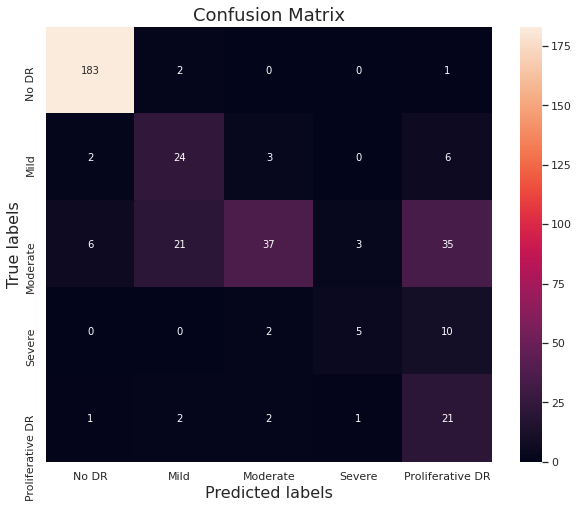

In [ ]:
y_pre = model.predict(X_test)
y_true = [np.argmax(element) for element in Y_test]
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

y_pred_classes = [np.argmax(element) for element in y_pre]
 
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

cnf_matrix = confusion_matrix(y_true, y_pred_classes)

labels = ["No DR","Mild","Moderate","Severe","Proliferative DR"]
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'16'}
ax.set_xlabel('Predicted labels', fontdict=label_font);ax.set_ylabel('True labels',fontdict=label_font); 
title_font = {'size':'18'}
ax.set_title('Confusion Matrix',fontdict=title_font);

ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);



#Focal Loss

In [ ]:
from tensorflow import keras
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        print(y_true)
        print(y_pred)
        epsilon = 1.e-9
        y_true = tf.dtypes.cast(y_true, tf.float32)
        #y_true = tf.convert_to_tensor(y_true, tf.float32)
        print("y_true", y_true)
        #y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
import keras
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import os
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

class QWKCallback(Callback):
    def __init__(self,val_data):
        super(Callback, self).__init__()
        self.validation_data = val_data
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201_bestqwk.h5')


from tensorflow import keras
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        print(y_true)
        print(y_pred)
        epsilon = 1.e-9
        y_true = tf.dtypes.cast(y_true, tf.float32)
        #y_true = tf.convert_to_tensor(y_true, tf.float32)
        print("y_true", y_true)
        #y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)

# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y


batch_size = 32
img_size = 224


X_train=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_train.npy')
Y_train=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_train.npy')
X_val=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_val.npy')
Y_val=np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_val.npy')
X_test = np.load('/content/drive/MyDrive/NhanDang/Data/3k6/X_test.npy')
Y_test = np.load('/content/drive/MyDrive/NhanDang/Data/3k6/Y_test.npy')

Y_train_labels = np.argmax(Y_train,axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train_labels),Y_train_labels)
cls_wt_dict = dict(enumerate(class_weights))
print(cls_wt_dict)

datagen = ImageDataGenerator(            
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=32, alpha=0.2, datagen=datagen)()
valid_generator = ImageDataGenerator(rescale=1./255)
validation = MixupGenerator(X_val, Y_val, batch_size=32, alpha=0.2, datagen=datagen)()


EPOCHS = 50
validation_data=(X_val, Y_val)
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201_bestqwk.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]



In [ ]:
densenet_weights_path = '/content/drive/MyDrive/NhanDang/Data/3k6/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3),include_top=False,weights=None,pooling='avg')
pretrained_model3.trainable = False
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(5, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss=FocalLoss(alpha = 0.5), metrics = ['accuracy', 'AUC'])

In [ ]:
model.fit(training_generator, epochs=5,
             steps_per_epoch=X_train.shape[0] // batch_size,
             validation_data=(X_val, Y_val), verbose=1, 
             callbacks = [mycallbacks],
             class_weight = cls_wt_dict)

Epoch 1/5
76/76 [==============================] - 879s 11s/step - loss: 1.5700 - accuracy: 0.4165 - auc: 0.7378 - val_loss: 1.5396 - val_accuracy: 0.4885 - val_auc: 0.7473

Epoch 00001: val_loss improved from inf to 1.53960, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 0 : QWK: 0.0
saving checkpoint:  0.0
Epoch 2/5
76/76 [==============================] - 855s 11s/step - loss: 1.6014 - accuracy: 0.4877 - auc: 0.7699 - val_loss: 1.5288 - val_accuracy: 0.4885 - val_auc: 0.7705

Epoch 00002: val_loss improved from 1.53960 to 1.52878, saving model to /content/drive/MyDrive/NhanDang/Data/3k6/DenseNet201.h5
Epoch 1 : QWK: 0.0
saving checkpoint:  0.0
Epoch 3/5
76/76 [==============================] - 862s 11s/step - loss: 1.6377 - accuracy: 0.4926 - auc: 0.7672 - val_loss: 1.5630 - val_accuracy: 0.4885 - val_auc: 0.6893

Epoch 00003: val_loss did not improve from 1.52878
Epoch 2 : QWK: 0.0
saving checkpoint:  0.0
Epoch 4/5
76/76 [=============================

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       186
           1       0.34      0.71      0.46        35
           2       0.74      0.33      0.46       102
           3       0.25      0.82      0.38        17
           4       1.00      0.07      0.14        27

    accuracy                           0.68       367
   macro avg       0.65      0.58      0.47       367
weighted avg       0.79      0.68      0.67       367



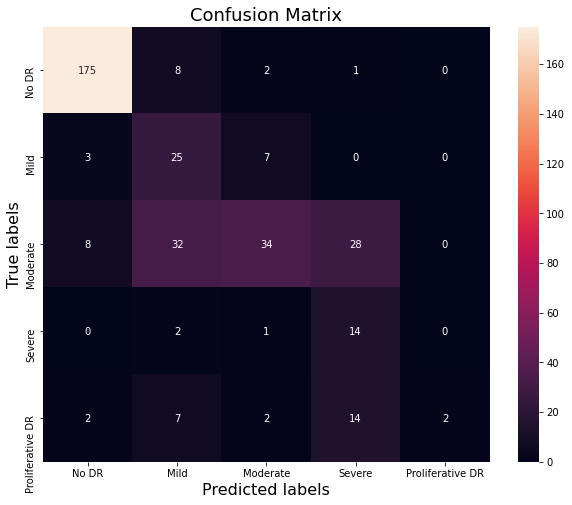

In [ ]:
y_true = [np.argmax(element) for element in Y_test]

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

y_pred_classes = [np.argmax(element) for element in y_pre]
 
print("Classification Report: \n", classification_report(y_true, y_pred_classes))

cnf_matrix = confusion_matrix(y_true, y_pred_classes)

labels = ["No DR","Mild","Moderate","Severe","Proliferative DR"]
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
label_font = {'size':'16'}
ax.set_xlabel('Predicted labels', fontdict=label_font);ax.set_ylabel('True labels',fontdict=label_font); 
title_font = {'size':'18'}
ax.set_title('Confusion Matrix',fontdict=title_font); 

ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);